In [2]:
import numpy as np
import matplotlib.pyplot as plt
from src.cluster.cluster import *
import os
import pandas as pd
from src.test.evaluate import *
from src.test.display_npy import *
from src.helper_functions import *
from src.data.preprocess import *
from src.data.full_mosaic_processing import *
import pandas as pd
from tqdm import tqdm
import rasterio
import pyproj
import cv2
import rasterio
from reproject_hapke import *


In [3]:
# Main execution
input_path = 'data/raw/Lunar_LRO_LROC-WAC_Mosaic_global_100m_June2013.tif'
output_path = 'data/raw/highpass_filtered_lunar_mosaic_sigma_100.tif'

convert_0_360_to_180_180(output_path, 'fixed_hapke_layer.tif')

Rolling image by 54582 pixels...


RasterioIOError: Write failed. See previous exception for details.

In [2]:
# Path to your combined craters .npy memmap
npy_path = "data/processed_filter/cae/craters.npy"  # adjust for mae/cae

# Check if file exists
if not os.path.exists(npy_path):
    print("File not found:", npy_path)
else:
    # Open memmap
    crater_memmap = np.memmap(npy_path, mode='r', dtype=np.float32)
    
    # Each crater is stored as (channels, 224, 224)
    channels, H, W = 1, 224, 224  # adjust for mae: channels=3
    
    # Compute total number of craters
    total_craters = crater_memmap.size // (channels * H * W)
    print(f"Memmap size (bytes): {crater_memmap.size * crater_memmap.dtype.itemsize}")
    print(f"Number of craters in memmap: {total_craters}")


Memmap size (bytes): 205087977472
Number of craters in memmap: 1021843


Memmap size (bytes): 205087977472
Number of craters in memmap: 1021843

Visualizing random samples...


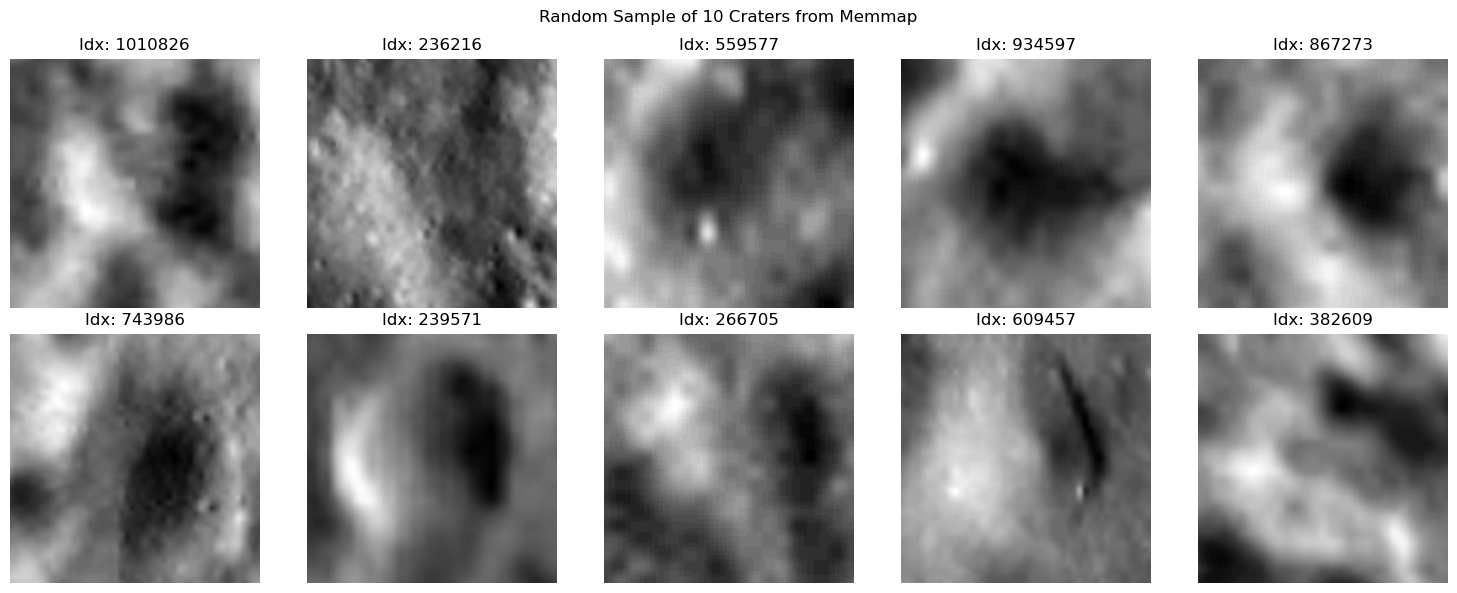

In [5]:
# Path to your combined craters .npy memmap
npy_path = "data/processed/cae/craters.npy"  # adjust for mae/cae

# Check if file exists
if not os.path.exists(npy_path):
    print("File not found:", npy_path)
else:
    # Open memmap
    # NOTE: If this was saved using np.save(), consider using: np.load(npy_path, mmap_mode='r')
    crater_memmap = np.memmap(npy_path, mode='r', dtype=np.float32)
    
    # Each crater is stored as (channels, 224, 224)
    channels, H, W = 1, 224, 224  # adjust for mae: channels=3
    
    # Compute total number of craters
    total_craters = crater_memmap.size // (channels * H * W)
    print(f"Memmap size (bytes): {crater_memmap.size * crater_memmap.dtype.itemsize}")
    print(f"Number of craters in memmap: {total_craters}")

    # --- NEW CODE START: Display 10 Craters ---
    if total_craters > 0:
        print("\nVisualizing random samples...")
        
        # Reshape the linear memmap to access individual images: (N, C, H, W)
        # We slice [:total*...] to ensure we don't include partial/garbage bytes at the end
        craters = crater_memmap[:total_craters * channels * H * W].reshape(total_craters, channels, H, W)

        # Select 10 random indices (or all if less than 10)
        num_samples = 10
        if total_craters < num_samples:
            indices = np.arange(total_craters)
        else:
            indices = np.random.choice(total_craters, num_samples, replace=False)

        # Create plot
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.ravel()

        for i, idx in enumerate(indices):
            # Extract image. Shape is (C, H, W) -> e.g., (1, 224, 224)
            img = craters[idx]
            
            # Prepare for Matplotlib (needs H, W, C or just H, W)
            if channels == 1:
                img_disp = img.squeeze()  # Becomes (224, 224)
                cmap = 'gray'
            else:
                img_disp = np.transpose(img, (1, 2, 0))  # Becomes (224, 224, 3)
                cmap = None

            # Handle Float32 Display: 
            # If values are not 0-1, imshow normalizes automatically. 
            # If you want to force it, uncomment the next line:
            # img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())

            axes[i].imshow(img_disp, cmap=cmap)
            axes[i].set_title(f"Idx: {idx}")
            axes[i].axis('off')

        plt.suptitle(f"Random Sample of {num_samples} Craters from Memmap")
        plt.tight_layout()
        plt.show()
    else:
        print("Memmap is empty or dimensions are incorrect.")

Memmap size (bytes): 205087977472
Number of craters in memmap: 1021843

Visualizing random samples...


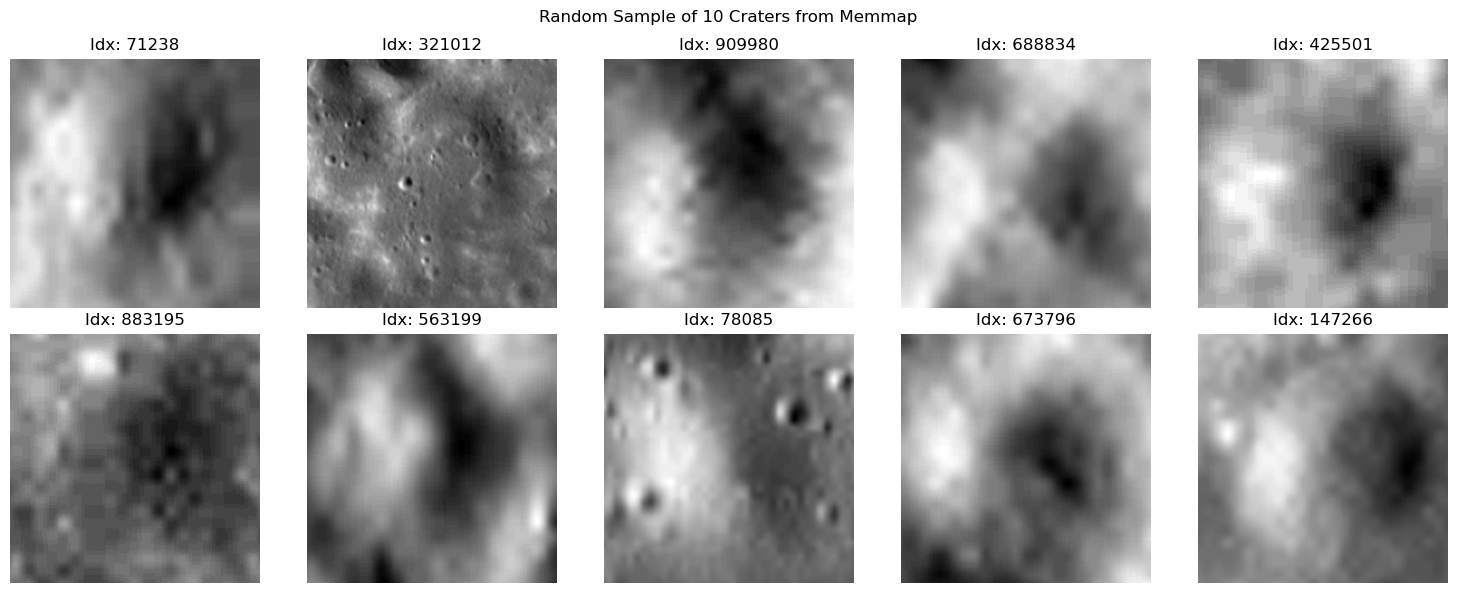

In [6]:
# Path to your combined craters .npy memmap
npy_path = "data/processed_filter/cae/craters.npy"  # adjust for mae/cae

# Check if file exists
if not os.path.exists(npy_path):
    print("File not found:", npy_path)
else:
    # Open memmap
    # NOTE: If this was saved using np.save(), consider using: np.load(npy_path, mmap_mode='r')
    crater_memmap = np.memmap(npy_path, mode='r', dtype=np.float32)
    
    # Each crater is stored as (channels, 224, 224)
    channels, H, W = 1, 224, 224  # adjust for mae: channels=3
    
    # Compute total number of craters
    total_craters = crater_memmap.size // (channels * H * W)
    print(f"Memmap size (bytes): {crater_memmap.size * crater_memmap.dtype.itemsize}")
    print(f"Number of craters in memmap: {total_craters}")

    # --- NEW CODE START: Display 10 Craters ---
    if total_craters > 0:
        print("\nVisualizing random samples...")
        
        # Reshape the linear memmap to access individual images: (N, C, H, W)
        # We slice [:total*...] to ensure we don't include partial/garbage bytes at the end
        craters = crater_memmap[:total_craters * channels * H * W].reshape(total_craters, channels, H, W)

        # Select 10 random indices (or all if less than 10)
        num_samples = 10
        if total_craters < num_samples:
            indices = np.arange(total_craters)
        else:
            indices = np.random.choice(total_craters, num_samples, replace=False)

        # Create plot
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.ravel()

        for i, idx in enumerate(indices):
            # Extract image. Shape is (C, H, W) -> e.g., (1, 224, 224)
            img = craters[idx]
            
            # Prepare for Matplotlib (needs H, W, C or just H, W)
            if channels == 1:
                img_disp = img.squeeze()  # Becomes (224, 224)
                cmap = 'gray'
            else:
                img_disp = np.transpose(img, (1, 2, 0))  # Becomes (224, 224, 3)
                cmap = None

            # Handle Float32 Display: 
            # If values are not 0-1, imshow normalizes automatically. 
            # If you want to force it, uncomment the next line:
            # img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())

            axes[i].imshow(img_disp, cmap=cmap)
            axes[i].set_title(f"Idx: {idx}")
            axes[i].axis('off')

        plt.suptitle(f"Random Sample of {num_samples} Craters from Memmap")
        plt.tight_layout()
        plt.show()
    else:
        print("Memmap is empty or dimensions are incorrect.")

In [ ]:
craters_csv = "data/raw/lunar_crater_database_robbins_2018.csv"
craters = pd.read_csv(craters_csv)

# Apply your preprocessing filters
filtered = craters[
    (craters['DIAM_CIRC_IMG'] >= 1.0) &
    (craters['DIAM_CIRC_IMG'] <= 10.0) &  # adjust thresholds if needed
    (craters['LAT_CIRC_IMG'] >= -60) &
    (craters['LAT_CIRC_IMG'] <= 60)
]

print("Total craters in CSV:", len(craters))
print("Crater count after filters:", len(filtered))

In [ ]:
craters_csv = "data/raw/lunar_crater_database_robbins_2018.csv"
map_file = "data/raw/Lunar_LRO_LROC-WAC_Mosaic_global_100m_June2013.tif"

craters = pd.read_csv(craters_csv)
filtered = craters[
    (craters['DIAM_CIRC_IMG'] >= 1.0) &
    (craters['DIAM_CIRC_IMG'] <= 10.0) &
    (craters['LAT_CIRC_IMG'] >= -60) &
    (craters['LAT_CIRC_IMG'] <= 60)
]

craters_crs = get_craters_crs()
processed_count = 0

with rasterio.open(map_file) as map_ref:
    transformer = pyproj.Transformer.from_crs(craters_crs, map_ref.crs.to_string(), always_xy=True)
    
    for _, crater in tqdm(filtered.iterrows(), total=len(filtered)):
        try:
            crop = crop_crater(map_ref, crater['LAT_CIRC_IMG'], crater['LON_CIRC_IMG'], crater['DIAM_CIRC_IMG'], 0.5, transformer)
            if crop is not None and crop.size > 0:
                processed_count += 1
        except:
            pass

print(f"Filtered craters: {len(filtered)}")
print(f"Successfully processed craters: {processed_count}")


In [ ]:

# Test MAE crops (RGB)
quick_test_preprocessing('data/processed_filter/mae/crater_crops', 'mae_craters_stats.npz', num_samples=20)

In [ ]:
# Simply call compare_clusters - it handles everything internally!
results = compare_clusters(
    technique='tsne',           # Visualization technique
    cluster_method='kmeans',    # Clustering method
    n_clusters=2,             # Number of clusters
    use_gpu=False,              # Set to True if you have GPU support
    out_dir="logs/cae/1.0_10.0_50_40/results",
    combine_labels=True,
    
)

# Results dictionary contains all metrics
print("\n=== SUMMARY ===")
print(f"ARI: {results['standard_metrics']['ari']:.3f}")
print(f"Procrustes disparity: {results['structural_similarity']['procrustes_disparity']:.4f}")
print(f"Distance correlation: {results['structural_similarity']['distance_correlation']:.3f}")
print(f"V-Measure: {results['structural_similarity']['v_measure']:.3f}")
print(f"Silhouette (predicted): {results['structural_similarity']['pred_silhouette']:.3f}")
print(f"Silhouette (ground truth): {results['structural_similarity']['gt_silhouette']:.3f}")
print(f"Boundary uncertainty: {results['continuum_evidence']['boundary_uncertainty']:.3f}")

In [ ]:
# Simply call compare_clusters - it handles everything internally!
results = compare_clusters(
    technique='tsne',           # Visualization technique
    cluster_method='agglomerative',    # Clustering method
    n_clusters=2,             # Number of clusters
    use_gpu=False,              # Set to True if you have GPU support
    out_dir="logs/mae/facebook/vit-mae-large/nofreeze_50_facemae_0.75_lower_lr_dataset_norm/results/",
    combine_labels=True
)

# Results dictionary contains all metrics
print("\n=== SUMMARY ===")
print(f"ARI: {results['standard_metrics']['ari']:.3f}")
print(f"Procrustes disparity: {results['structural_similarity']['procrustes_disparity']:.4f}")
print(f"Distance correlation: {results['structural_similarity']['distance_correlation']:.3f}")
print(f"V-Measure: {results['structural_similarity']['v_measure']:.3f}")
print(f"Silhouette (predicted): {results['structural_similarity']['pred_silhouette']:.3f}")
print(f"Silhouette (ground truth): {results['structural_similarity']['gt_silhouette']:.3f}")
print(f"Boundary uncertainty: {results['continuum_evidence']['boundary_uncertainty']:.3f}")

In [ ]:
# Simply call compare_clusters - it handles everything internally!
results = compare_clusters(
    technique='pca',           # Visualization technique
    cluster_method='kmeans',    # Clustering method
    n_clusters=2,             # Number of clusters
    use_gpu=False,              # Set to True if you have GPU support
    out_dir="logs/mae/facebook/vit-mae-large/nofreeze_50_facemae_0.75_lower_lr_dataset_norm/results/",
    combine_labels=True
)

# Results dictionary contains all metrics
print("\n=== SUMMARY ===")
print(f"ARI: {results['standard_metrics']['ari']:.3f}")
print(f"Procrustes disparity: {results['structural_similarity']['procrustes_disparity']:.4f}")
print(f"Distance correlation: {results['structural_similarity']['distance_correlation']:.3f}")
print(f"V-Measure: {results['structural_similarity']['v_measure']:.3f}")
print(f"Silhouette (predicted): {results['structural_similarity']['pred_silhouette']:.3f}")
print(f"Silhouette (ground truth): {results['structural_similarity']['gt_silhouette']:.3f}")
print(f"Boundary uncertainty: {results['continuum_evidence']['boundary_uncertainty']:.3f}")

In [ ]:
# Simply call compare_clusters - it handles everything internally!
results = compare_clusters(
    technique='tsne',           # Visualization technique
    cluster_method='agglomerative',    # Clustering method
    n_clusters=3,             # Number of clusters
    use_gpu=False,              # Set to True if you have GPU support
    out_dir="logs/cae/facebook/vit-mae-large/0_50_40/results"
)

# Results dictionary contains all metrics
print("\n=== SUMMARY ===")
print(f"ARI: {results['standard_metrics']['ari']:.3f}")
print(f"Procrustes disparity: {results['structural_similarity']['procrustes_disparity']:.4f}")
print(f"Distance correlation: {results['structural_similarity']['distance_correlation']:.3f}")
print(f"V-Measure: {results['structural_similarity']['v_measure']:.3f}")
print(f"Silhouette (predicted): {results['structural_similarity']['pred_silhouette']:.3f}")
print(f"Silhouette (ground truth): {results['structural_similarity']['gt_silhouette']:.3f}")
print(f"Boundary uncertainty: {results['continuum_evidence']['boundary_uncertainty']:.3f}")

In [ ]:
# Simply call compare_clusters - it handles everything internally!
results = compare_clusters(
    technique='umap',           # Visualization technique
    cluster_method='kmeans',    # Clustering method
    n_clusters=3,             # Number of clusters
    use_gpu=False,              # Set to True if you have GPU support
    out_dir="logs/cnn_latent40_l2_sched_pca/results/"
)

# Results dictionary contains all metrics
print("\n=== SUMMARY ===")
print(f"ARI: {results['standard_metrics']['ari']:.3f}")
print(f"Procrustes disparity: {results['structural_similarity']['procrustes_disparity']:.4f}")
print(f"Distance correlation: {results['structural_similarity']['distance_correlation']:.3f}")
print(f"V-Measure: {results['structural_similarity']['v_measure']:.3f}")
print(f"Silhouette (predicted): {results['structural_similarity']['pred_silhouette']:.3f}")
print(f"Silhouette (ground truth): {results['structural_similarity']['gt_silhouette']:.3f}")
print(f"Boundary uncertainty: {results['continuum_evidence']['boundary_uncertainty']:.3f}")

Original latent dim: 40
Finished Clustering! Clustering method: kmeans, Number of clusters: 4
[PCA] Total variance explained (PC1+PC2): 31.98%
Saved plots to logs/cae/sigma50_1.0_10.0_25_40/results/
Found 4 clusters

Cluster 0: 35 samples

Cluster 1: 38 samples

Cluster 2: 40 samples

Cluster 3: 37 samples

Figure saved to: logs/cae/sigma50_1.0_10.0_25_40/results/craters_examples_by_cluster.png


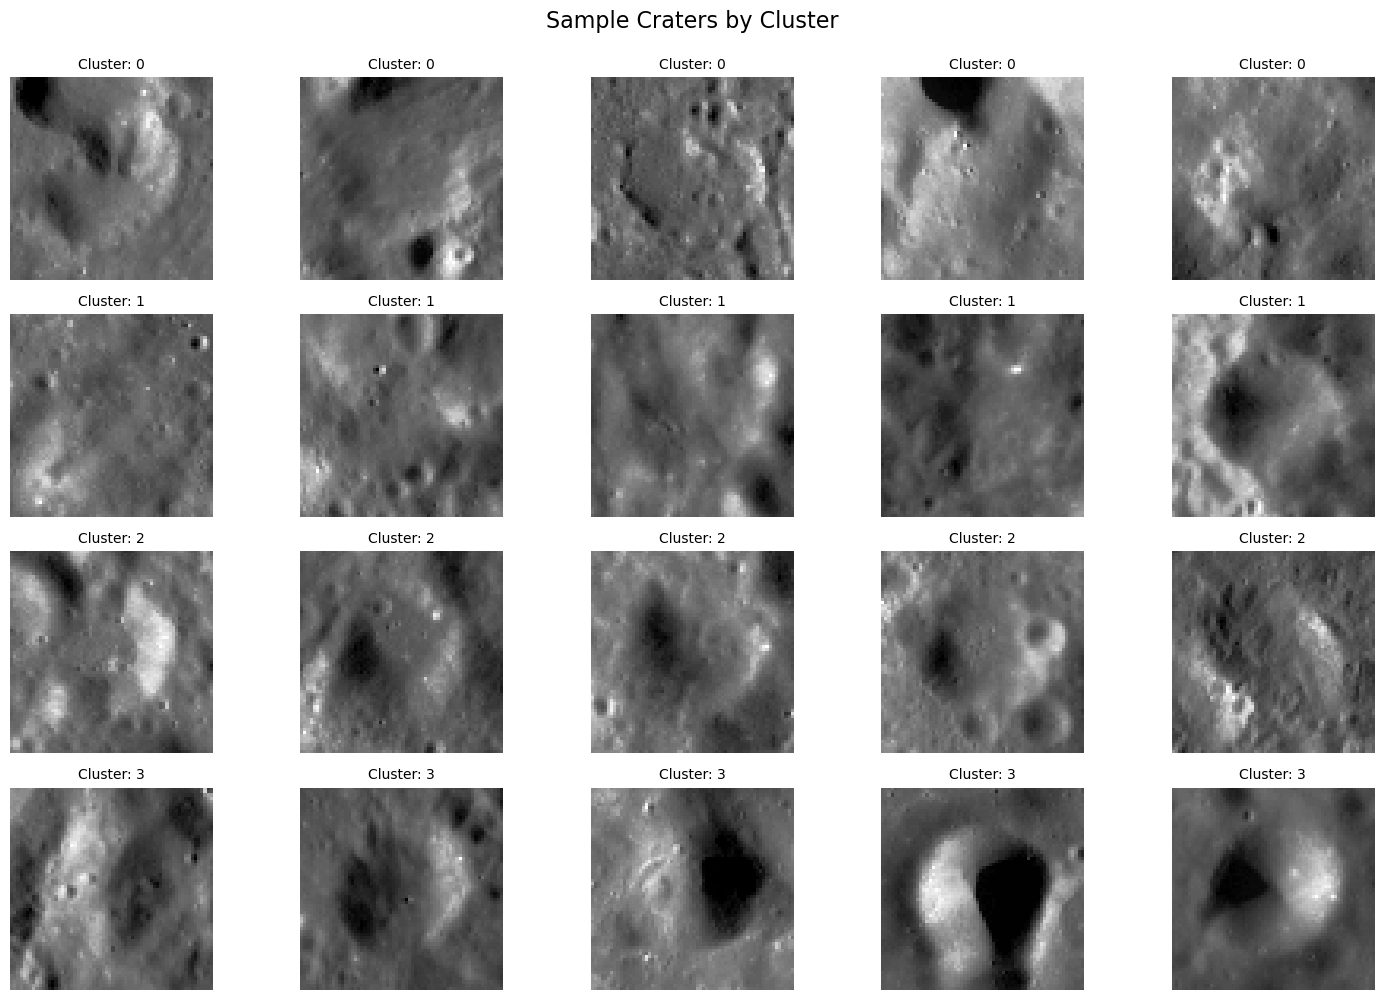

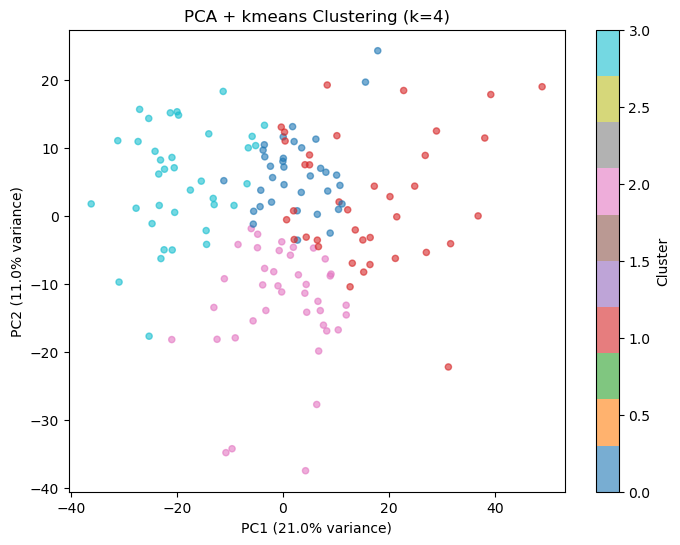

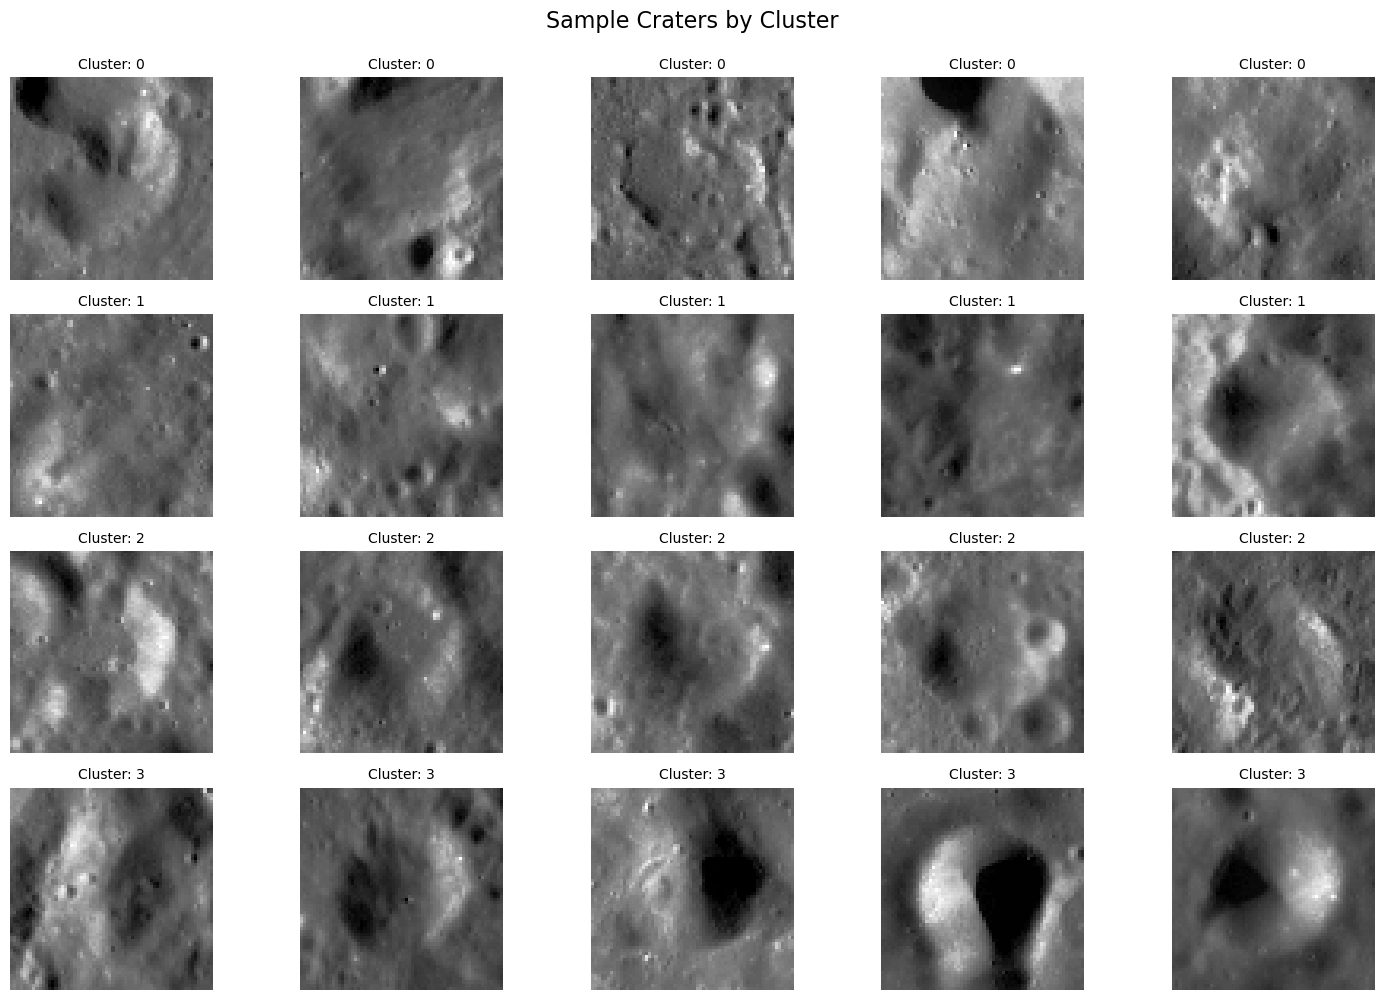

In [7]:
STATE_LABELS = {
    1: "New Crater",
    2: "Semi New Crater",
    3: "Semi Old Crater",
    4: "Old Crater"
}
STATE_COLORS = {
    1: "tab:blue",
    2: "tab:green",
    3: "tab:orange",
    4: "tab:red"
}

# Run clustering with ground truth visualization
_, _, _, labels = cluster_and_plot(
    latent="logs/cae/sigma50_1.0_10.0_25_40/results/latents.npy",
    technique='pca',
    cluster_method='kmeans',
    n_clusters=4,
    save_path="logs/cae/sigma50_1.0_10.0_25_40/results/"
)

display_craters_by_cluster(
    cluster_labels=labels,
    imgs_dir="data/raw/craters_for_danny",
    samples_per_cluster=5,
    save_path="logs/cae/sigma50_1.0_10.0_25_40/results/craters_examples_by_cluster.png"
)


In [ ]:
STATE_LABELS = {
    1: "New Crater",
    2: "Semi New Crater",
    3: "Semi Old Crater",
    4: "Old Crater"
}
STATE_COLORS = {
    1: "tab:blue",
    2: "tab:green",
    3: "tab:orange",
    4: "tab:red"
}

# Load ground truth labels
ground_truth = np.load("logs/cnn_latent40_l2_sched_1_10/results/states.npy").squeeze()  # .squeeze() to remove extra dimensions

# Run clustering with ground truth visualization
fig_gmm, fig_gt, coords, labels = cluster_and_plot(
    latent="logs/cnn_latent40_l2_sched_1_10/results/latents.npy",
    technique='umap',
    cluster_method='kmeans',
    n_clusters=4,
    save_path="logs/cnn_latent40_l2_sched_1_10/results/",
    ground_truth_labels=ground_truth,
    state_labels=STATE_LABELS,
    state_colors=STATE_COLORS,
    imgs_dir="data/raw/craters_for_danny"  # or provide path if you want image scatter
)

display_craters_by_cluster(
    cluster_labels=labels,
    imgs_dir="data/raw/craters_for_danny",
    samples_per_cluster=5,
    save_path="logs/cnn_latent40_l2_sched_1_10/results/craters_examples_by_cluster.png"
)


In [ ]:
# Define new combined state labels
COMBINED_STATE_LABELS = {
    1: "New/Semi-New Crater",  # Combines states 1 and 2
    2: "Old/Semi-Old Crater"    # Combines states 3 and 4
}

COMBINED_STATE_COLORS = {
    1: "tab:blue",
    2: "tab:red"
}

# Load ground truth labels
ground_truth = np.load("logs/cnn_latent40_l2_sched_pca/results/states.npy").squeeze()

# Remap the labels to combine states
# Map: 1->1, 2->1, 3->2, 4->2
label_mapping = {1: 1, 2: 1, 3: 2, 4: 2}
combined_ground_truth = np.array([label_mapping[label] for label in ground_truth])

# Run clustering with combined ground truth visualization
fig_gmm, fig_gt, coords, labels = cluster_and_plot(
    latent="logs/cnn_latent40_l2_sched_pca/results/latents.npy",
    technique='tsne',
    cluster_method='kmeans',
    n_clusters=2,  # Changed to 2 since you now have 2 combined states
    save_path="logs/cae_latent40_l2_sched_pca/results/",
    ground_truth_labels=combined_ground_truth,
    state_labels=COMBINED_STATE_LABELS,
    state_colors=COMBINED_STATE_COLORS,
    imgs_dir="data/raw/craters_for_danny"
)

In [ ]:
STATE_LABELS = {
    1: "New Crater",
    2: "Semi New Crater",
    3: "Semi Old Crater",
    4: "Old Crater"
}
STATE_COLORS = {
    1: "tab:blue",
    2: "tab:green",
    3: "tab:orange",
    4: "tab:red"
}

# Load ground truth labels
ground_truth = np.load("logs/mae/facebook/vit-mae-large/nofreeze_50_facemae_0.75_lower_lr_dataset_norm/results/states.npy").squeeze()  # .squeeze() to remove extra dimensions

# Run clustering with ground truth visualization
fig_gmm, fig_gt, coords, labels = cluster_and_plot(
    latent="logs/mae/facebook/vit-mae-large/nofreeze_50_facemae_0.75_lower_lr_dataset_norm/results/latent_vectors.npy",
    technique='pca',
    cluster_method='kmeans',
    n_clusters=3,
    save_path="logs/mae/facebook/vit-mae-large/nofreeze_50_facemae_0.75_lower_lr_dataset_norm/results/",
    ground_truth_labels=ground_truth,
    state_labels=STATE_LABELS,
    state_colors=STATE_COLORS,
    reduce_latent_95=True,
    use_gpu=True)

In [ ]:
STATE_LABELS = {
    1: "New Crater",
    2: "Semi New Crater",
    3: "Semi Old Crater",
    4: "Old Crater"
}
STATE_COLORS = {
    1: "tab:blue",
    2: "tab:green",
    3: "tab:orange",
    4: "tab:red"
}

# Load ground truth labels
ground_truth = np.load("logs/cnn_latent40_l2_sched_500/results/states.npy").squeeze()  # .squeeze() to remove extra dimensions

# Run clustering with ground truth visualization
fig_gmm, fig_gt, coords, labels = cluster_and_plot(
    latent="logs/cnn_latent40_l2_sched_500/results/latents.npy",
    technique='umap',
    cluster_method='kmeans',
    n_clusters=3,
    save_path="logs/cnn_latent40_l2_sched_500/results/new_validation/",
    ground_truth_labels=ground_truth,
    state_labels=STATE_LABELS,
    state_colors=STATE_COLORS,
    imgs_dir="data/raw/craters_for_danny"  # or provide path if you want image scatter
)

In [ ]:
STATE_LABELS = {
    1: "New Crater",
    2: "Semi New Crater",
    3: "Semi Old Crater",
    4: "Old Crater"
}
STATE_COLORS = {
    1: "tab:blue",
    2: "tab:green",
    3: "tab:orange",
    4: "tab:red"
}

# Load ground truth labels
ground_truth = np.load("logs/cnn_latent40_l2_sched_1_10/results/states.npy").squeeze()  # .squeeze() to remove extra dimensions

# Run clustering with ground truth visualization
fig_gmm, fig_gt, coords, labels = cluster_and_plot(
    latent="logs/cnn_latent40_l2_sched_1_10/results/latents.npy",
    technique='umap',
    cluster_method='kmeans',
    n_clusters=3,
    save_path="logs/cnn_latent40_l2_sched_1_10/results/new_validation/",
    ground_truth_labels=ground_truth,
    state_labels=STATE_LABELS,
    state_colors=STATE_COLORS,
    imgs_dir="data/raw/craters_for_danny"  # or provide path if you want image scatter
)

In [ ]:
STATE_LABELS = {
    1: "New Crater",
    2: "Semi New Crater",
    3: "Semi Old Crater",
    4: "Old Crater"
}
STATE_COLORS = {
    1: "tab:blue",
    2: "tab:green",
    3: "tab:orange",
    4: "tab:red"
}

# Load ground truth labels
ground_truth = np.load("logs/cnn_latent40_l2_sched_pca/results/states.npy").squeeze()  # .squeeze() to remove extra dimensions

# Run clustering with ground truth visualization
fig_gmm, fig_gt, coords, labels = cluster_and_plot(
    latent="logs/cae/facebook/vit-mae-large/0_50_40/results/latents.npy",
    technique='pca',
    cluster_method='agglomerative',
    n_clusters=3,
    save_path="logs/cae/facebook/vit-mae-large/0_50_40/results/",
    ground_truth_labels=ground_truth,
    state_labels=STATE_LABELS,
    state_colors=STATE_COLORS,
    imgs_dir="data/raw/craters_for_danny"  # or provide path if you want image scatter
)

In [ ]:
STATE_LABELS = {
    1: "New Crater",
    2: "Semi New Crater",
    3: "Semi Old Crater",
    4: "Old Crater"
}
STATE_COLORS = {
    1: "tab:blue",
    2: "tab:green",
    3: "tab:orange",
    4: "tab:red"
}

# Load ground truth labels
ground_truth = np.load("logs/mae/facebook/vit-mae-large/nofreeze_50_facemae_0.75_lower_lr_dataset_norm/results/states_julie.npy").squeeze()  # .squeeze() to remove extra dimensions

# Run clustering with ground truth visualization
fig_gmm, fig_gt, coords, labels = cluster_and_plot(
    latent="logs/mae/facebook/vit-mae-large/nofreeze_50_facemae_0.75_lower_lr_dataset_norm/results/latents_julie_with_flip.npy",
    technique='tsne',
    cluster_method='agglomerative',
    n_clusters=3,
    save_path="logs/mae/facebook/vit-mae-large/nofreeze_50_facemae_0.75_lower_lr_dataset_norm/results/",
    ground_truth_labels=ground_truth,
    state_labels=STATE_LABELS,
    state_colors=STATE_COLORS,
    imgs_dir="data/raw/craters_for_danny"  # or provide path if you want image scatter
)

In [ ]:
STATE_LABELS = {
    1: "New Crater",
    2: "Semi New Crater",
    3: "Semi Old Crater",
    4: "Old Crater"
}
STATE_COLORS = {
    1: "tab:blue",
    2: "tab:green",
    3: "tab:orange",
    4: "tab:red"
}

# Load ground truth labels
ground_truth = np.load("logs/cae_latent40_l2_sched_1_10/results/states.npy").squeeze()  # .squeeze() to remove extra dimensions

# Run clustering with ground truth visualization
fig_gmm, fig_gt, coords, labels = cluster_and_plot(
    latent="logs/cae_latent40_l2_sched_1_10/results/latents.npy",
    technique='tsne',
    cluster_method='agglomerative',
    n_clusters=3,
    save_path="logs/cae_latent40_l2_sched_1_10/results/",
    ground_truth_labels=ground_truth,
    state_labels=STATE_LABELS,
    state_colors=STATE_COLORS,
    imgs_dir="data/raw/craters_for_danny"  # or provide path if you want image scatter
    )